# **EXPERIMENT 4:** Prototype `Research Agent` with Agent Component + FastAPI

# 1. Introduction


*   This experiment prototypes the existing Research Agent using the new Agent and utilizes experimental MultiFileConverter SuperComponent for our use-case.

# 2. Setup Phase

In [46]:
! uv pip install haystack-ai haystack-experimental google-ai-haystack fastapi uvicorn nest_asyncio arize-phoenix openinference-instrumentation-haystack httpx duckduckgo-api-haystack python-dotenv jsonschema trafilatura pypdf markdown-it-py mdit_plain docstring-parser python-pptx python-docx jq pandas openpyxl tabulate

Using Python 3.13.2 environment at: C:\Users\angel\Documents\GitHub\ambitus-ai-models\.venv
Audited 23 packages in 39ms


### Load `.env` file

In [2]:
from dotenv import load_dotenv

load_dotenv() # Load environment variable

True

### Enable Arize-Phoenix for tracing

In [ ]:
from phoenix.otel import register
import phoenix as px
from openinference.instrumentation.haystack import HaystackInstrumentor

px.launch_app()
tracer_provider = register(project_name="Research Agent")
HaystackInstrumentor().instrument(tracer_provider=tracer_provider)

c:\Users\angel\Documents\GitHub\ambitus-ai-models\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix
OpenTelemetry Tracing Details
|  Phoenix Project: Research Agent
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: localhost:4317
|  Transport: gRPC
|  Transport Headers: {'user-agent': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  WARNING: It is strongly advised to use a BatchSpanProcessor in production environments.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



INFO:     127.0.0.1:57027 - "POST /graphql HTTP/1.1" 200 OK
INFO:     127.0.0.1:57028 - "POST /graphql HTTP/1.1" 200 OK
INFO:     127.0.0.1:57028 - "POST /graphql HTTP/1.1" 200 OK
INFO:     127.0.0.1:57027 - "POST /graphql HTTP/1.1" 200 OK
INFO:     127.0.0.1:57028 - "POST /graphql HTTP/1.1" 200 OK
INFO:     127.0.0.1:57028 - "POST /graphql HTTP/1.1" 200 OK
INFO:     127.0.0.1:57028 - "POST /graphql HTTP/1.1" 200 OK
INFO:     127.0.0.1:57028 - "POST /graphql HTTP/1.1" 200 OK
INFO:     127.0.0.1:57028 - "POST /graphql HTTP/1.1" 200 OK
INFO:     127.0.0.1:57028 - "POST /graphql HTTP/1.1" 200 OK
INFO:     127.0.0.1:57028 - "POST /graphql HTTP/1.1" 200 OK
INFO:     127.0.0.1:57032 - "POST /graphql HTTP/1.1" 200 OK
INFO:     127.0.0.1:57032 - "POST /graphql HTTP/1.1" 200 OK
INFO:     127.0.0.1:57032 - "POST /graphql HTTP/1.1" 200 OK
INFO:     127.0.0.1:57028 - "POST /graphql HTTP/1.1" 200 OK
INFO:     127.0.0.1:57028 - "POST /graphql HTTP/1.1" 200 OK
INFO:     127.0.0.1:57033 - "POST /graph

### Import Packages

In [4]:
from haystack import Pipeline
from haystack.utils import Secret
from haystack.components.agents import Agent 
from haystack.components.fetchers import LinkContentFetcher
from haystack_experimental.super_components.converters import MultiFileConverter
from haystack.components.builders.chat_prompt_builder import ChatPromptBuilder
from haystack_integrations.components.generators.google_ai import GoogleAIGeminiChatGenerator
from duckduckgo_api_haystack import DuckduckgoApiWebSearch
from haystack.components.builders.answer_builder import AnswerBuilder
from haystack.dataclasses import ChatMessage
from haystack.tools.tool import Tool
from haystack.core.super_component import SuperComponent
from haystack.tools import ComponentTool

# 3. Search Tool Setup

### Initializing Tool Pipeline

In [5]:
search_pipe = Pipeline()
""" 
prompt_template = [
    ChatMessage.from_user(
    '''
    According to the following documents:
    {% for document in documents %}
    {{document.content}}
    {% endfor %}
    '''
    )
]

prompt_template2 = [
    ChatMessage.from_user(
    '''
    {% for doc in docs %}
    <search-result url="{{ doc.meta.url }}">
    {{ doc.content|default|truncate(25000) }}
    </search-result>
    {% endfor %}
    '''
    )
]
 """
search_pipe.add_component("search", DuckduckgoApiWebSearch(top_k=10, backend="html"))
search_pipe.add_component("fetcher", LinkContentFetcher(timeout=3, raise_on_failure=False, retry_attempts=2))
search_pipe.add_component("converter", MultiFileConverter())
search_pipe.add_component(
    "prompt_builder", 
    ChatPromptBuilder(
        template=[
            ChatMessage.from_user(
                """
                {% for doc in docs %}
                <search-result url="{{ doc.meta.link }}">
                {{ doc.content|default|truncate(25000) }}
                </search-result>
                {% endfor %}
                {% for document in documents %}
                {{document.content}}
                {% endfor %}
                """
            )
        ],
        variables=["docs", "documents"],
        required_variables=["docs", "documents"]
    )
)

### Connections

In [6]:
search_pipe.connect("search.links", "fetcher.urls")
search_pipe.connect("fetcher.streams", "converter.sources")
search_pipe.connect("converter.documents", "prompt_builder.documents")
search_pipe.connect("search.documents", "prompt_builder.docs")

🚅 Components
  - search: DuckduckgoApiWebSearch
  - fetcher: LinkContentFetcher
  - converter: MultiFileConverter
  - prompt_builder: ChatPromptBuilder
🛤️ Connections
  - search.links -> fetcher.urls (List[str])
  - search.documents -> prompt_builder.docs (List[Document])
  - fetcher.streams -> converter.sources (List[ByteStream])
  - converter.documents -> prompt_builder.documents (List[Document])

### Visualization

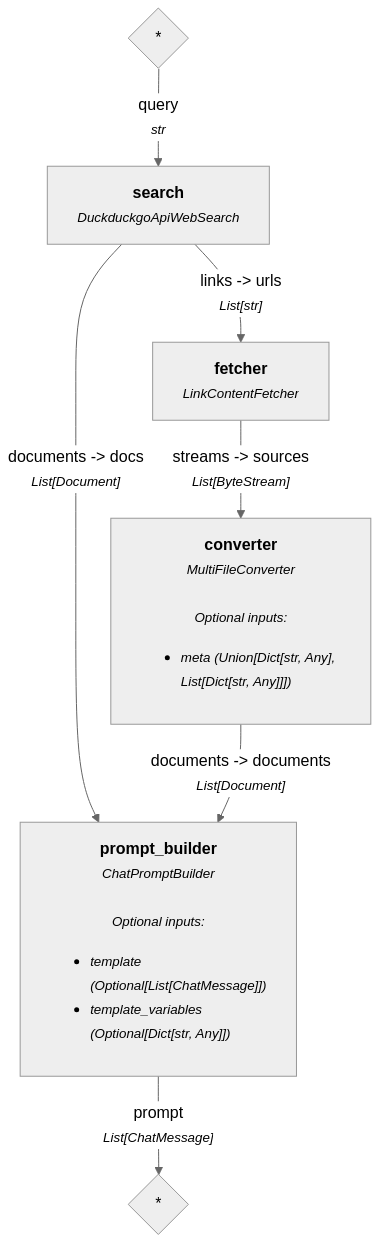

In [7]:
search_pipe.show()

### Testing Pipeline

In [8]:
search_query = "Zepto business model and strategy analysis"

test_response = search_pipe.run(
    {"query": search_query},
)

In [9]:
test_response

{'prompt_builder': {'prompt': [ChatMessage(_role=<ChatRole.USER: 'user'>, _content=[TextContent(text='\n                \n                <search-result url="https://startuptalky.com/zepto-business-model/">\n                The "dark store model" serves as the foundation for Zepto\'s business model. This involves setting up delivery-only warehouse-style stores in residential regions. The shops sell a variety of products, and the sole way for buyers to place orders is through the Zepto India website or app. Across multiple regions, Zepto now has more than eighty-six ...\n                </search-result>\n                \n                <search-result url="https://www.latterly.org/zepto-business-model/">\n                The Zepto Business Model not only emphasizes speed and convenience but also fosters a loyal customer base, which is crucial in a market projected to be valued at USD 2.9 billion by 2028. As the company continues to expand its footprint across India, its dark store stra

### Tooling

In [10]:
# Wrap in SuperComponent + ComponentTool
search_tool_component = SuperComponent(
    pipeline=search_pipe,
    input_mapping={
        "query": ["search.query"],
    },
    output_mapping={"prompt_builder.prompt": "replies"}
    )
search_tool = ComponentTool(
    name="webSearch",
    description="Use this tool to search for information on the internet to be added in the research work. Input format: {query: <search query>}",
    component=search_tool_component
)

# 4. Agent Setup

## Utilising LLM: `gemini-2.5-pro-exp-03-25`

### Initialisation

In [11]:
# Build the Chat Generator
chat_generator = GoogleAIGeminiChatGenerator(model="gemini-2.5-pro-exp-03-25")

# Create the Agent
agent = Agent(
    chat_generator=chat_generator,
    tools=[search_tool],
    system_prompt="""
You are a deep research assistant for a target industry/company.
You create comprehensive research reports to answer the user's questions.
Gather data on market trends, competitors, and dynamics.
Break the user question into smaller parts and answer each part separately using tools.
You MUST use the 'webSearch'-tool to answer any questions.
You MUST utilize the 'webSearch'-tool to search for information on the internet.
You perform multiple searches until you have the information you need to answer the question.
Make sure you research different aspects of the question.
Use markdown to format your response.
When you use information from the websearch results, cite your sources using markdown links.
It is important that you cite accurately, use links from 'webSearch' tool ONLY.
""",
    exit_conditions=["text"],
    max_agent_steps=100,
    raise_on_tool_invocation_failure=True
)

agent.warm_up()

### Testing Response

In [12]:
# Answer builder
answer_builder = AnswerBuilder()

# Simulate input
query = "Analyze Zepto's current business, technical, and marketing strategies. Provide insights into their key technical domains, ongoing and upcoming projects, recently released products, and innovative approaches in marketing. Highlight how these strategies have contributed to their growth."


messages = [ChatMessage.from_user(query)]

# Run agent
agent_output = agent.run(messages=messages)

# Filter replies with valid 'text' only
valid_replies = [msg for msg in agent_output["messages"] if getattr(msg, "text", None)]

answers = answer_builder.run(query=query, replies=valid_replies)

# Print the result
for answer in answers["answers"]:
    print(answer)

GeneratedAnswer(data="\nYou are a deep research assistant for a target industry/company.\nYou create comprehensive research reports to answer the user's questions.\nGather data on market trends, competitors, and dynamics.\nBreak the user question into smaller parts and answer each part separately using tools.\nYou MUST use the 'webSearch'-tool to answer any questions.\nYou MUST utilize the 'webSearch'-tool to search for information on the internet.\nYou perform multiple searches until you have the information you need to answer the question.\nMake sure you research different aspects of the question.\nUse markdown to format your response.\nWhen you use information from the websearch results, cite your sources using markdown links.\nIt is important that you cite accurately, use links from 'webSearch' tool ONLY.\n", query="Analyze Zepto's current business, technical, and marketing strategies. Provide insights into their key technical domains, ongoing and upcoming projects, recently releas

## Understanding Response

### Raw Response

In [13]:
agent_output["messages"]

[ChatMessage(_role=<ChatRole.SYSTEM: 'system'>, _content=[TextContent(text="\nYou are a deep research assistant for a target industry/company.\nYou create comprehensive research reports to answer the user's questions.\nGather data on market trends, competitors, and dynamics.\nBreak the user question into smaller parts and answer each part separately using tools.\nYou MUST use the 'webSearch'-tool to answer any questions.\nYou MUST utilize the 'webSearch'-tool to search for information on the internet.\nYou perform multiple searches until you have the information you need to answer the question.\nMake sure you research different aspects of the question.\nUse markdown to format your response.\nWhen you use information from the websearch results, cite your sources using markdown links.\nIt is important that you cite accurately, use links from 'webSearch' tool ONLY.\n")], _name=None, _meta={}),
 ChatMessage(_role=<ChatRole.USER: 'user'>, _content=[TextContent(text="Analyze Zepto's current 

In [14]:
from IPython.display import display, Markdown
display(Markdown(answers["answers"][-1].data)) # Print the final answer

Okay, here's an analysis of Zepto's current business, technical, and marketing strategies, drawing upon available information.

**I. Zepto's Business Strategy**

Zepto operates in the highly competitive quick commerce (q-commerce) sector in India, focusing on ultra-fast delivery of groceries and essentials.

1.  **Core Value Proposition:** The foundation of Zepto's business is speed, initially built around the promise of 10-minute grocery delivery [[1](https://www.mindinventory.com/blog/zepto-business-model/)]. While optimizing operations, they maintain a focus on rapid delivery, typically within 10-20 minutes.
2.  **Dark Store Model:** Zepto utilizes a network of strategically located "dark stores" or micro-fulfillment centers. These are not open to the public but are optimized for quick picking and packing of orders within a limited radius [[1](https://www.mindinventory.com/blog/zepto-business-model/)] [[2](https://economictimes.indiatimes.com/tech/startups/zepto-pivots-to-prioritise-profitability-over-10-minute-delivery-model/articleshow/101275109.cms)]. This dense network is crucial for enabling fast delivery times.
3.  **Target Market:** Primarily urban and semi-urban consumers who prioritize convenience and speed over potentially wider selections or slightly lower prices found in traditional supermarkets or slower e-commerce platforms [[1](https://www.mindinventory.com/blog/zepto-business-model/)].
4.  **Path to Profitability:** After initial rapid expansion focused on market share, Zepto has increasingly emphasized achieving positive unit economics and overall profitability. This involves optimizing delivery routes, improving supply chain efficiency, increasing average order value (AOV), and potentially introducing handling fees in some cases [[2](https://economictimes.indiatimes.com/tech/startups/zepto-pivots-to-prioritise-profitability-over-10-minute-delivery-model/articleshow/101275109.cms)] [[4](https://inc42.com/buzz/zepto-to-raise-300-mn-funding-at-up-to-2-5-bn-valuation/)]. They achieved unicorn status in August 2023 after raising $200 million [[5](https://techcrunch.com/2023/08/25/zepto-becomes-first-indian-unicorn-of-2023/)].
5.  **Expansion & Diversification:** Zepto has expanded its product categories beyond core groceries to include items like electronics, home essentials, and potentially beauty products, aiming to increase basket size and customer loyalty. They also launched "Zepto Cafe" in select locations, offering ready-to-drink coffee, tea, and snacks [[3](https://techcrunch.com/2022/04/26/indias-zepto-widens-10-minute-delivery-offering-with-snacks-and-beverages/)].

*   **Contribution to Growth:** The core 10-minute delivery promise was a powerful initial growth driver, attracting significant customer interest and venture capital. The dark store model provides the operational backbone for this speed. The shift towards profitability and category expansion aims to create a sustainable long-term growth trajectory, moving beyond just rapid customer acquisition.

**II. Zepto's Technical Strategy**

Technology is central to enabling Zepto's business model.

1.  **Supply Chain & Inventory Management:** Sophisticated systems are used to manage inventory in real-time across numerous dark stores, predict demand, minimize wastage (especially for fresh produce), and ensure product availability [[1](https://www.mindinventory.com/blog/zepto-business-model/)].
2.  **Logistics & Delivery Optimization:** Technology optimizes every stage of delivery:
    *   **Location Intelligence:** Data analysis determines optimal dark store locations based on population density, demand patterns, and road networks [[1](https://www.mindinventory.com/blog/zepto-business-model/)].
    *   **Order Allocation:** Algorithms instantly assign orders to the nearest dark store with available inventory.
    *   **Route Planning:** Dynamic routing algorithms guide riders on the fastest paths, considering real-time traffic data.
    *   **Rider Management:** Systems manage rider allocation, tracking, and performance.
3.  **Data Analytics & AI/ML:** Data science plays a crucial role in demand forecasting, inventory planning, delivery time prediction, customer behavior analysis, and personalization [[1](https://www.mindinventory.com/blog/zepto-business-model/)].
4.  **Platform Engineering:** Robust and scalable mobile apps (iOS/Android) and backend systems are necessary to handle high order volumes, real-time tracking, secure payments, and a smooth user experience.

*   **Contribution to Growth:** Technology directly enables the core promise of speed and reliability. Efficient logistics reduce delivery costs and improve customer satisfaction. Data analytics helps optimize inventory, reducing waste and improving margins. A seamless app experience encourages repeat usage. Scalable tech infrastructure allows Zepto to expand its operations rapidly.

**III. Zepto's Marketing Strategy**

Zepto's marketing focuses on highlighting its core value proposition – speed and convenience.

1.  **Digital First Approach:** Heavy reliance on digital marketing channels, including performance marketing (search ads, social media ads), social media engagement, and content marketing.
2.  **Hyper-local Targeting:** Marketing efforts are often targeted geographically around their dark store service areas to reach potential customers within the delivery radius.
3.  **Emphasis on Speed:** The "10-minute delivery" (or similar rapid delivery messaging) remains a central theme in advertising and communication [[1](https://www.mindinventory.com/blog/zepto-business-model/)].
4.  **Promotions and Offers:** Utilizes introductory offers for new customers, referral bonuses, and category-specific discounts to drive acquisition and encourage trials.
5.  **Influencer Marketing & Partnerships:** Collaborating with social media influencers and potentially local partnerships to build brand awareness and trust.
6.  **Brand Building:** Campaigns often focus on use cases where speed is essential (e.g., running out of an ingredient while cooking, urgent needs). They have also used celebrity endorsements in some campaigns.

*   **Contribution to Growth:** Marketing creates awareness of Zepto's unique selling proposition (speed) and drives customer acquisition, especially in new launch areas. Promotions incentivize trial and build initial user bases. Digital channels allow for targeted and measurable campaigns, optimizing marketing spend for growth.

**IV. Key Technical Domains**

*   **Supply Chain Technology:** Real-time inventory tracking, Warehouse Management Systems (WMS) optimized for micro-fulfillment.
*   **Logistics & Geospatial Technology:** Route optimization, real-time tracking, location analytics, ETA calculation.
*   **Data Science & Analytics:** Demand forecasting, customer segmentation, personalization engines, A/B testing platforms.
*   **Platform & Mobile Engineering:** Scalable backend infrastructure (likely cloud-based microservices), robust customer-facing mobile applications.

**V. Ongoing/Upcoming Projects & Recent Releases**

*   **Zepto Cafe:** Expansion of the quick delivery model to include freshly prepared beverages and snacks [[3](https://techcrunch.com/2022/04/26/indias-zepto-widens-10-minute-delivery-offering-with-snacks-and-beverages/)].
*   **Category Expansion:** Continuously adding new product categories beyond groceries (e.g., electronics, gifting, home goods) to increase AOV.
*   **Profitability Initiatives:** Ongoing projects focused on optimizing operations, potentially introducing private-label products, refining delivery fees, and improving supply chain efficiency to reach profitability [[2](https://economictimes.indiatimes.com/tech/startups/zepto-pivots-to-prioritise-profitability-over-10-minute-delivery-model/articleshow/101275109.cms)].
*   **Geographic Expansion:** While likely more measured than in the initial phase, expansion into new pin codes or cities remains a possibility, driven by data on market potential and operational feasibility.
*   **Potential Fundraising:** Reports suggest Zepto might be seeking further funding rounds to fuel growth and solidify its market position [[4](https://inc42.com/buzz/zepto-to-raise-300-mn-funding-at-up-to-2-5-bn-valuation/)].

**VI. Innovative Marketing Approaches**

*   **Extreme Focus on Speed:** While common in q-commerce, Zepto's initial relentless focus on the specific "10-minute" mark was a bold and differentiating marketing message that captured attention.
*   **Hyper-local Digital Campaigns:** Tailoring digital ads very specifically to the neighborhoods served by each dark store maximizes relevance and efficiency.
*   **Use-Case Driven Content:** Marketing content often highlights specific moments or needs where instant delivery is highly valuable, making the service relatable.

In conclusion, Zepto's growth has been driven by a synergistic strategy: a bold business model focused on unprecedented speed, enabled by sophisticated technology for logistics and operations, and communicated effectively through targeted, digitally-focused marketing. The current phase involves refining this model for sustainable profitability while continuing to innovate in product offerings and operational efficiency.

## Utilising LLM: `gemini-2.0-flash`

### Initialisation

In [15]:
# Build the Chat Generator
chat_generator = GoogleAIGeminiChatGenerator(model="gemini-2.0-flash")

# Create the Agent
agent = Agent(
    chat_generator=chat_generator,
    tools=[search_tool],
    system_prompt="""
You are a deep research assistant for a target industry/company.
You create comprehensive research reports to answer the user's questions.
Gather data on market trends, competitors, and dynamics.
You must use the 'search_tool'-tool to answer any questions.
You perform multiple searches until you have the information you need to answer the question.
Make sure you research different aspects of the question.
Use markdown to format your response.
When you use information from the websearch results, cite your sources using markdown links.
It is important that you cite accurately.
""",
    exit_conditions=["text"],
    max_agent_steps=100,
    raise_on_tool_invocation_failure=True
)

agent.warm_up()

### Testing Response

In [23]:
# Answer builder
answer_builder = AnswerBuilder()

# Simulate input
query = "Analyze Zepto's current business, technical, and marketing strategies. Provide insights into their key technical domains, ongoing and upcoming projects, recently released products, and innovative approaches in marketing. Highlight how these strategies have contributed to their growth."
messages.clear() # Clear previous messages
messages = [ChatMessage.from_user(query)]

# Run agent
agent_output = agent.run(messages=messages)

# Filter replies with valid 'text' only
valid_replies = [msg for msg in agent_output["messages"] if getattr(msg, "text", None)]

answers = answer_builder.run(query=query, replies=valid_replies)

# Print the result
for answer in answers["answers"]:
    print(answer)

GeneratedAnswer(data="\nYou are a deep research assistant for a target industry/company.\nYou create comprehensive research reports to answer the user's questions.\nGather data on market trends, competitors, and dynamics.\nYou must use the 'webSearch'-tool to answer any questions.\nYou perform multiple searches until you have the information you need to answer the question.\nMake sure you research different aspects of the question.\nUse markdown to format your response.\nWhen you use information from the websearch results, cite your sources using markdown links.\nIt is important that you cite accurately.\n", query="Analyze Zepto's current business, technical, and marketing strategies. Provide insights into their key technical domains, ongoing and upcoming projects, recently released products, and innovative approaches in marketing. Highlight how these strategies have contributed to their growth.", documents=[], meta={})
GeneratedAnswer(data="Analyze Zepto's current business, technical,

## Understanding Response

### Raw Response

In [24]:
agent_output["messages"]

[ChatMessage(_role=<ChatRole.SYSTEM: 'system'>, _content=[TextContent(text="\nYou are a deep research assistant for a target industry/company.\nYou create comprehensive research reports to answer the user's questions.\nGather data on market trends, competitors, and dynamics.\nYou must use the 'webSearch'-tool to answer any questions.\nYou perform multiple searches until you have the information you need to answer the question.\nMake sure you research different aspects of the question.\nUse markdown to format your response.\nWhen you use information from the websearch results, cite your sources using markdown links.\nIt is important that you cite accurately.\n")], _name=None, _meta={}),
 ChatMessage(_role=<ChatRole.USER: 'user'>, _content=[TextContent(text="Analyze Zepto's current business, technical, and marketing strategies. Provide insights into their key technical domains, ongoing and upcoming projects, recently released products, and innovative approaches in marketing. Highlight ho

In [25]:
from IPython.display import display, Markdown
display(Markdown(answers["answers"][-1].data)) # Print the final answer

Zepto's strategy revolves around quick commerce, with a primary focus on ultra-fast grocery delivery (10 minutes). The following is a breakdown of its business, technical, and marketing strategies:

## Business Strategy

*   **Quick Commerce Model:**
    *   Zepto’s main value proposition is delivering groceries within 10 minutes, catering to time-conscious urban consumers.
*   **Dark Store Network:**
    *   Zepto operates a network of dark stores (micro-fulfillment centers) strategically located in high-demand urban areas.
    *   These stores are not open to the public, ensuring efficient order fulfillment and inventory management.
*   **Hyperlocal Delivery:**
    *   Zepto uses a hyperlocal delivery model, sourcing products from the closest dark stores.
*   **Customer-Centric Approach:**
    *   Zepto focuses on a seamless app experience for easy browsing, ordering, and payment.
    *   They also provide customer support.
*   **Revenue Model:**
    *   Commission fees from grocery stores (2-3% of the order value).
    *   Delivery fees for smaller orders, and subscription-based delivery models.
    *   Advertising and premium listings for brands.
    *   Private label products to improve margins.
    *   Data monetization through consumer insights.

## Technical Strategy

*   **AI-Powered Technology:**
    *   Zepto uses AI to optimize inventory, manage supply chains, and predict demand.
    *   AI algorithms streamline order processing and delivery logistics.
*   **Geolocation and Data Analytics:**
    *   Utilizing location intelligence and geospatial data to determine the best dark store locations.
    *   Data analytics to optimize delivery routes (real-time traffic, weather conditions).
*   **Mobile App Focus:**
    *   User-friendly app interface for easy ordering and real-time tracking.
    *   In-house systems to communicate orders to operational staff.
*   **Scalable Infrastructure:**
    *   Investing in scalable infrastructure, including dark stores and efficient logistics.

## Marketing Strategy

*   **Branding and Advertising:**
    *   Emphasizing the 10-minute delivery promise in advertising campaigns.
    *   Using a strong brand name and tagline.
    *   Employing relatable and humorous marketing campaigns.
    *   Partnering with the advertising agency L&K Saatchi & Saatchi.
*   **Social Media and Influencer Marketing:**
    *   Creating engaging content on platforms like Instagram and Facebook.
    *   Collaborating with influencers to promote services and build brand awareness.
    *   Utilizing meme marketing to connect with younger audiences.
*   **Targeted Campaigns:**
    *   Running targeted campaigns for specific demographics and locations.
*   **Promotional Deals and Referral Programs:**
    *   Offering attractive discounts, promotions, and referral incentives.
*   **Partnerships:**
    *   Collaborating with local brands for cross-promotion.

## Key Technical Domains

*   **Logistics:**
    *   Route optimization.
    *   Order dispatch in 60-90 seconds.
*   **Inventory Management:**
    *   AI-driven inventory management for demand prediction and supply chain optimization.
*   **Mobile App Development:**
    *   User-friendly and reliable app with features like real-time tracking.

## Ongoing and Upcoming Projects

*   **Geographical Expansion:**
    *   Expanding to new cities, including Tier 2 and Tier 3 cities.
*   **Product Diversification:**
    *   Exploring new categories such as electronics and pharmacy.
    *   Launching Zepto Café.
*   **Technological Advancements:**
    *   Continuous investment in AI and automation for improved efficiency.

## Recently Released Products

*   **Apple Products:**
    *   Delivery of Apple products (iPhones, AirPods, etc.) in select cities.
*   **Lenskart Phonic:**
    *   Partnership with Lenskart to deliver smart eyewear (Phonic) in 10 minutes.

## Innovative Approaches in Marketing

*   **10-Minute Delivery as USP:** The core focus on speed and convenience.
*   **Meme Marketing:** Creating relatable and shareable content.
*   **Influencer Partnerships:** Leveraging influencers for brand promotion.
*   **Celebrity Partnerships:** Using brand ambassadors to drive sales, like the campaign with Jasprit Bumrah.

## How Strategies Have Contributed to Growth

*   **High Growth:** Zepto has experienced significant growth in both revenue and customer base.
    *   Reported a 200% monthly customer base expansion rate.
    *   Reported a 140% year-on-year growth.
    *   Reaching an annualized Gross Order Value (GOV) of $4 billion, with a 30% increase since January 2025.
*   **Brand Recognition:** The marketing strategies have helped Zepto build strong brand recognition.
*   **Customer Loyalty:**
    *   Focus on customer-centricity leading to high retention rates.
    *   Zepto claims to have a customer retention rate of 60%.
*   **Operational Efficiency:**
    *   Use of dark stores and technology has made operations efficient.
    *   Average delivery time of 8 minutes and 47 seconds.
    *   Achieved 75% EBITDA positivity in dark stores by May 2024.
*   **Investment:**
    *   Secured over $1.6 billion in funding in the past three years.
    *   Zepto is now valued at $5 billion.


## Utilising LLM: `gemini-2.0-flash-lite`

### Initialisation

In [19]:
# Build the Chat Generator
chat_generator = GoogleAIGeminiChatGenerator(model="gemini-2.0-flash-lite")

# Create the Agent
agent = Agent(
    chat_generator=chat_generator,
    tools=[search_tool],
    system_prompt="""
You are a deep research assistant for a target industry/company.
You create comprehensive research reports to answer the user's questions.
Gather data on market trends, competitors, and dynamics.
You must use the 'webSearch'-tool to answer any questions.
You perform multiple searches until you have the information you need to answer the question.
Make sure you research different aspects of the question.
Use markdown to format your response.
When you use information from the websearch results, cite your sources using markdown links.
It is important that you cite accurately.
""",
    exit_conditions=["text"],
    max_agent_steps=100,
    raise_on_tool_invocation_failure=True
)

agent.warm_up()

### Testing Response

In [20]:
# Answer builder
answer_builder = AnswerBuilder()

# Simulate input
query = "Analyze Zepto's current business, technical, and marketing strategies. Provide insights into their key technical domains, ongoing and upcoming projects, recently released products, and innovative approaches in marketing. Highlight how these strategies have contributed to their growth."
messages.clear() # Clear previous messages
messages = [ChatMessage.from_user(query)]

# Run agent
agent_output = agent.run(messages=messages)

# Filter replies with valid 'text' only
valid_replies = [msg for msg in agent_output["messages"] if getattr(msg, "text", None)]

answers = answer_builder.run(query=query, replies=valid_replies)

# Print the result
for answer in answers["answers"]:
    print(answer)

GeneratedAnswer(data="\nYou are a deep research assistant for a target industry/company.\nYou create comprehensive research reports to answer the user's questions.\nGather data on market trends, competitors, and dynamics.\nYou must use the 'webSearch'-tool to answer any questions.\nYou perform multiple searches until you have the information you need to answer the question.\nMake sure you research different aspects of the question.\nUse markdown to format your response.\nWhen you use information from the websearch results, cite your sources using markdown links.\nIt is important that you cite accurately.\n", query="Analyze Zepto's current business, technical, and marketing strategies. Provide insights into their key technical domains, ongoing and upcoming projects, recently released products, and innovative approaches in marketing. Highlight how these strategies have contributed to their growth.", documents=[], meta={})
GeneratedAnswer(data="Analyze Zepto's current business, technical,

## Understanding Response

### Raw Response

In [21]:
agent_output["messages"]

[ChatMessage(_role=<ChatRole.SYSTEM: 'system'>, _content=[TextContent(text="\nYou are a deep research assistant for a target industry/company.\nYou create comprehensive research reports to answer the user's questions.\nGather data on market trends, competitors, and dynamics.\nYou must use the 'webSearch'-tool to answer any questions.\nYou perform multiple searches until you have the information you need to answer the question.\nMake sure you research different aspects of the question.\nUse markdown to format your response.\nWhen you use information from the websearch results, cite your sources using markdown links.\nIt is important that you cite accurately.\n")], _name=None, _meta={}),
 ChatMessage(_role=<ChatRole.USER: 'user'>, _content=[TextContent(text="Analyze Zepto's current business, technical, and marketing strategies. Provide insights into their key technical domains, ongoing and upcoming projects, recently released products, and innovative approaches in marketing. Highlight ho

In [22]:
from IPython.display import display, Markdown
display(Markdown(answers["answers"][-1].data)) # Print the final answer

Zepto's business model centers around ultra-fast, 10-minute grocery delivery, a quick-commerce (q-commerce) model. Here's a breakdown of their strategies:

**1. Business Strategy**

*   **Quick Commerce Model**: Zepto delivers groceries and essentials within 10 minutes, differentiating it from traditional e-commerce.
*   **Dark Stores**: They operate a network of dark stores (micro-fulfillment centers) in densely populated areas, optimized for speed. These are not open to the public and stock commonly ordered items.
*   **Hyperlocal Delivery**: They use a hyperlocal delivery model, with an algorithm-based system for route planning and efficient delivery personnel utilization.
*   **App-Based Ordering**: A user-friendly app allows quick browsing, ordering, and real-time tracking.
*   **Revenue Streams**:
    *   Product Margins: Revenue from selling groceries and essentials.
    *   Delivery Charges: Fees for smaller orders, with free delivery above a certain threshold. Subscription-based delivery is also an option.
    *   Advertising and Promotional Listings: Revenue from brand advertisements on the platform.
    *   Private Label Products: Higher profit margins from their private-label brands.
    *   Data Monetization: Potential for long-term monetization through customer data insights.

**2. Technical Domains**

*   **AI and Machine Learning**: Used for optimizing inventory, supply chains, and demand prediction within dark stores.
*   **Data Analytics**: Employed for efficient route planning, determining dark store locations, and understanding consumer behavior.
*   **App Technology**: A user-friendly app for easy ordering, product browsing, and real-time order tracking.

**3. Marketing Strategies**

*   **10-Minute Delivery Emphasis**: Zepto’s marketing focuses on speed and convenience.
*   **Digital Marketing**: Zepto uses social media, influencer marketing, and digital channels.
*   **Meme Marketing**: Zepto leverages social media trends for engagement.
*   **Referral Programs**: These incentivize both new and existing users.
*   **Partnerships**: Collaboration with influencers.
*   **Advertising**: Emphasis on the 10-minute delivery feature.

**4. Product Releases**

*   Zepto cafe is expanding its food and beverage offerings.

**5. Innovative Approaches**

*   **Speed and Convenience**: The core of Zepto’s value proposition.
*   **Dark Store Model**: Enables fast order fulfillment.
*   **Technology Integration**: Optimizes various aspects of the business.

**6. Contributions to Growth**

*   **Speed**: The 10-minute delivery promise has attracted customers and set them apart from competitors.
*   **Technology**: AI and data analytics have improved operational efficiency.
*   **Customer Experience**: The app's ease of use and real-time tracking enhance customer satisfaction.

**7. Competitors**:

*   Blinkit
*   Swiggy Instamart
*   BigBasket
*   Dunzo

**8. Challenges**

*   **High Competition**: The quick-commerce market has fierce competition.
*   **Logistics Costs**: Maintaining delivery personnel and dark store operations.
*   **Customer Retention**: Retaining customers in a competitive market.
*   **Regulatory Scrutiny**: The quick-commerce industry is under scrutiny regarding delivery personnel.

**9. Key Financials:**

*   **Valuation**: $3.6 Billion (June 2024)
*   **Operating Revenue:** INR 4,454 crore (FY24)
*   **Losses**: INR 1,248 crore (FY24)

**10. IPO**

*   Zepto plans to go public in 2025.

In summary, Zepto's strategy focuses on fast delivery, technology, and customer convenience to gain a strong position in the Indian quick-commerce market.


# 5. Restful APIs for the Agent

## 5.1 Agent Setup

### Agent : LLM `gemini-2.0-flash`

In [43]:
# Build the Chat Generator
chat_generator = GoogleAIGeminiChatGenerator(model="gemini-2.0-flash")

# Create the Agent
agent = Agent(
    chat_generator=chat_generator,
    tools=[search_tool],
    system_prompt="""
You are a deep research assistant for a target industry/company.
You create comprehensive research reports to answer the user's questions.
Gather data on market trends, competitors, and dynamics.
You must use the 'webSearch'-tool to answer any questions.
You perform multiple searches until you have the information you need to answer the question.
Make sure you research different aspects of the question.
Use markdown to format your response.
When you use information from the websearch results, cite your sources using markdown links.
It is important that you cite accurately.
""",
    exit_conditions=["text"],
    max_agent_steps=100,
    raise_on_tool_invocation_failure=True
)

agent.warm_up()

# Answer builder
answer_builder = AnswerBuilder()

# Simulate input
query = "Analyze Zepto's current business, technical, and marketing strategies. Provide insights into their key technical domains, ongoing and upcoming projects, recently released products, and innovative approaches in marketing. Highlight how these strategies have contributed to their growth."
messages.clear() # Clear previous messages
messages = [ChatMessage.from_user(query)]

# Run agent
agent_output = agent.run(messages=messages)

# Filter replies with valid 'text' only
valid_replies = [msg for msg in agent_output["messages"] if getattr(msg, "text", None)]

answers = answer_builder.run(query=query, replies=valid_replies)

# Print the result
for answer in answers["answers"]:
    print(answer)

GeneratedAnswer(data="\nYou are a deep research assistant for a target industry/company.\nYou create comprehensive research reports to answer the user's questions.\nGather data on market trends, competitors, and dynamics.\nYou must use the 'webSearch'-tool to answer any questions.\nYou perform multiple searches until you have the information you need to answer the question.\nMake sure you research different aspects of the question.\nUse markdown to format your response.\nWhen you use information from the websearch results, cite your sources using markdown links.\nIt is important that you cite accurately.\n", query="Analyze Zepto's current business, technical, and marketing strategies. Provide insights into their key technical domains, ongoing and upcoming projects, recently released products, and innovative approaches in marketing. Highlight how these strategies have contributed to their growth.", documents=[], meta={})
GeneratedAnswer(data="Analyze Zepto's current business, technical,

#### Output

In [44]:
display(Markdown(answers["answers"][-1].data))

Based on the search results, here are some ongoing and upcoming projects and recently released products for Zepto:

*   **Expanding Dark Store Network:** Zepto aims to significantly increase its number of dark stores, planning to double its existing count from 350 to over 700 by March 2025 and potentially reaching 1,000 stores.  This expansion aims to enhance delivery capabilities and customer reach.
*   **Geographical Expansion:** Zepto intends to expand its presence into 10 new cities.
*   **New Product Categories:** Zepto is launching new product categories to 10X customer experience. These new categories aim to diversify its offerings.
*   **Zepto Pass Expansion:** Initiatives like expanding Zepto Pass, a subscription-based program, are in the works to improve customer loyalty.
*   **Expanded Initiatives:** Zepto plans to launch major new projects that will improve customer experience.
*   **Non-Grocery Segments:** Gross sales from non-grocery segments like electronics, apparel and general merchandise have increased.
*   **Delivering Apple Products:** Zepto expanded its offerings to include delivering Apple products in select cities.
*   **Zepto Cafe:** Zepto is planning to open a Zepto café that will provide popular brand’s coffee and tea.
*   **Electric Vehicle Fleets:** The company plans to explore electric vehicle fleets for deliveries, reduce its carbon footprint, and expand its tech capabilities to create a seamless, data-driven delivery experience.
*   **Preparing for IPO:** The company is working towards an IPO, streamlining operations, and improving profitability to attract public market investors. Zepto is considering increasing the size of its initial public offering (IPO) to $800 million-$1 billion, which includes secondary shares

**Key Technical Domains**

Based on the research, Zepto's key technical domains appear to be:

*   **Data Science and Analytics:** Applying data science to understand buying patterns, preferences, and demand trends.
*   **AI and Machine Learning:** Using AI and ML to optimize inventory, manage supply chains, and predict demand.
*   **Mobile Technology:** Developing and maintaining a user-friendly mobile app for ordering and personalization.

**In summary:**

Zepto's success stems from its tightly integrated business, technical, and marketing strategies. Its business strategy focuses on ultra-fast delivery through strategically located dark stores. The technical strategy leverages AI and data analytics to optimize logistics and the customer experience. The marketing strategy emphasizes brand awareness, customer acquisition, and retention through diverse channels. By continuously innovating and adapting, Zepto is poised for continued growth in the competitive quick commerce market.


## 5.2 FastAPI App

In [48]:
from fastapi import FastAPI, HTTPException
from fastapi.responses import JSONResponse
from pydantic import BaseModel

app = FastAPI()

class QueryInput(BaseModel):
    query: str

@app.post("/query")
async def get_agent_response(input_data: QueryInput):
    try:
        # Clear and update message history
        messages.clear()
        messages.extend([ChatMessage.from_user(input_data.query)])

        # Run the agent
        agent_output = agent.run(messages=messages)

        # Filter valid replies
        valid_replies = [msg for msg in agent_output["messages"] if getattr(msg, "text", None)]

        # Generate answers
        answers = answer_builder.run(query=input_data.query, replies=valid_replies)

        # Extract the final answer
        result = answers["answers"][-1].data

        return JSONResponse(content={"response": result})
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

### Running

In [ ]:
import nest_asyncio
import threading
import uvicorn

nest_asyncio.apply()

def run_app():
    uvicorn.run(app, host="127.0.0.1", port=8000)

thread = threading.Thread(target=run_app, daemon=True)
thread.start()

INFO:     Started server process [19856]
INFO:     Waiting for application startup.


INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:56966 - "POST /query HTTP/1.1" 200 OK


### Testing

In [50]:
print(query)

Analyze Zepto's current business, technical, and marketing strategies. Provide insights into their key technical domains, ongoing and upcoming projects, recently released products, and innovative approaches in marketing. Highlight how these strategies have contributed to their growth.


In [51]:
import requests

response = requests.post("http://127.0.0.1:8000/query", json={"query": query})
response.json()

{'response': 'Based on the web search results, here\'s an analysis of Zepto\'s current business, technical, and marketing strategies:\n\n**1. Business Strategy:**\n\n*   **Quick Commerce Model:** Zepto operates on a quick-commerce (q-commerce) model, focusing on delivering groceries and daily essentials in ultra-short time frames. Their core value proposition is 10-minute delivery, setting them apart from traditional e-commerce players.\n*   **Dark Store Network:**  A key element of Zepto\'s business model is its network of strategically located dark stores (micro-fulfillment centers) in high-demand urban areas. These dark stores are optimized for efficient order processing and rapid delivery.\n*   **Customer-Centric Approach:** Zepto emphasizes customer convenience and satisfaction, aiming to provide a seamless and user-friendly online grocery shopping experience.\n*   **Revenue Model:** Zepto generates revenue through commission fees from partner grocery stores, delivery fees, advert

### Displaying Response

In [52]:
display(Markdown(response.json()["response"]))

Based on the web search results, here's an analysis of Zepto's current business, technical, and marketing strategies:

**1. Business Strategy:**

*   **Quick Commerce Model:** Zepto operates on a quick-commerce (q-commerce) model, focusing on delivering groceries and daily essentials in ultra-short time frames. Their core value proposition is 10-minute delivery, setting them apart from traditional e-commerce players.
*   **Dark Store Network:**  A key element of Zepto's business model is its network of strategically located dark stores (micro-fulfillment centers) in high-demand urban areas. These dark stores are optimized for efficient order processing and rapid delivery.
*   **Customer-Centric Approach:** Zepto emphasizes customer convenience and satisfaction, aiming to provide a seamless and user-friendly online grocery shopping experience.
*   **Revenue Model:** Zepto generates revenue through commission fees from partner grocery stores, delivery fees, advertisements and promotions, and potentially data monetization. They are also experimenting with a subscription model.

**2. Technical Strategy:**

*   **AI and Machine Learning:** Zepto leverages AI and machine learning for various purposes including:
    *   Optimizing inventory management
    *   Predicting demand and forecasting supply needs
    *   Route optimization and efficient delivery
    *   Dark store location selection
*   **Real-time Tracking:** Zepto uses real-time tracking apps to manage its delivery network and provide customers with accurate ETA predictions.
*   **Handheld Software:** Warehouse staff are equipped with handheld devices that guide them through the most optimal pathways for picking items, minimizing human decision-making and errors.
*  **Focus on data-driven decision-making:** Zepto utilizes data to optimize operations and inventory management.

**3. Marketing Strategy:**

*   **Target Audience:** Zepto primarily targets busy, urban consumers, including young professionals, students, and families who value convenience and speed.
*   **10-Minute Delivery Promise:** This is a core element of their marketing, emphasizing speed and convenience.
*   **Advertising and Branding:** Zepto utilizes advertising to build a strong brand image. L&K Saatchi and Saatchi is one of the advertising agencies working with Zepto.
*   **Social Media Marketing:** Zepto leverages social media platforms like Instagram, Facebook, and Twitter, using meme marketing to engage the audience.
*   **Influencer Marketing:** Collaborations with social media influencers help Zepto build trust and reach a wider audience.
*   **Micro-Moments Marketing:** They focus on sending the right messages at the right time to connect with customers during key moments in their journey.
*   **Referral Programs:** Zepto's referral program offers unique codes to users for sharing, incentivizing both existing and new users with rewards.
*   **Brand Ambassadors:**  Zepto has collaborated with celebrities like Jasprit Bumrah.

**4. Key Technical Domains:**

*   **Logistics and Supply Chain Optimization:** This is a critical technical domain, focusing on route optimization, delivery time prediction, and efficient warehouse management.
*   **AI-powered Inventory Management:** AI algorithms help predict demand, manage inventory dynamically, and ensure product availability.
*   **Mobile App Development:** A user-friendly mobile app is central to Zepto's operations, providing a seamless ordering and tracking experience for customers.
*   **Data Analytics:** Collecting and analyzing customer and operational data to improve decision-making and personalize the customer experience.

**5. Projects and Recent Releases:**

*   **Zepto Pass:** Zepto launched a membership subscription program (Zepto Pass) to offer free delivery.
*   **Zepto Cafe:** Launching a standalone app for its food and beverage division, Zepto Cafe, to compete with existing food delivery services and increase revenue.
*  **Delivery of Apple Products:** Zepto has entered the fast-paced race of delivering Apple products, including iPhones and AirPods, in 10 minutes.
*   **"Return and Recycle" Initiative:** Zepto has launched a ‘return and recycle’ initiative aimed at reducing waste and promoting sustainability within the supply chain.
*   **Zepto Daily (replacing Zepto Pass):** A new subscription plan is expected to come with extra benefits for select customers with an invite-only entry fee.

**6. Contribution to Growth:**

*   **Ultra-Fast Delivery:** Zepto’s 10-minute delivery promise has been a major driver of customer acquisition and brand recognition.
*   **Dark Store Efficiency:** The dark store model enables quick order fulfillment and optimized logistics.
*   **Targeted Marketing:** Data-driven marketing strategies, including social media engagement and influencer partnerships, have helped Zepto reach its target audience and build brand loyalty.
*   **Technology Integration:** Using AI and data analytics to optimize operations, improve efficiency, and enhance the customer experience has supported Zepto's rapid scaling.
*   **Funding:** Zepto's ability to raise significant funding has enabled it to expand its dark store network, invest in technology, and scale its operations.

In summary, Zepto's success is attributable to a combination of a customer-centric business model, innovative technical solutions, and a data-driven marketing strategy. These elements, particularly the focus on ultra-fast delivery and efficient dark store operations, have enabled Zepto to achieve rapid growth and establish a strong presence in the competitive quick commerce market in India. However, it is important to note that the business is still loss-making and needs to improve unit economics for long-term sustainability.


# 6. Observations and Conclusions

## 6.1. Observations

| Model | Response Quality | Tool Calling | Response Time | Notes |
|-------|------------------|--------------|---------------|-------|
| `gemini-2.5-pro-preview` | Excellent | Inconsistent (0-8 calls) | 40s without tools<br>~2m 30s with tools | • Highest quality results<br>• Minimal hallucination<br>• Leverages Google's internal grounding |
| `gemini-2.0-flash` | Good | Consistent (up to 8 calls) | 40s-1m depending on tool calls | • Good balance of speed and research depth<br>• Shallow responses can be improved via prompting |
| `gemini-2.0-flash-lite` | Basic | Consistent (1-3 calls) | 25-35s | • Fastest response times<br>• Consistently grounded with search results<br>• Most shallow analysis |

Our experiment evaluated three Google Gemini models for the research agent prototype, with each showing distinct characteristics:

- `gemini-2.5-pro-preview`: Produced the highest quality results but struggled with inconsistent tool calling behavior. While it occasionally made up to 8 tool calls resulting in comprehensive research, it frequently failed to utilize tools at all. Response generation took approximately 40 seconds without tool use and up to 2 minutes 30 seconds with tool use. Notably, it demonstrated minimal hallucination even without tool use, potentially due to Google's internal search-based grounding techniques.

- `gemini-2.0-flash`: Demonstrated the most consistent tool calling pattern, reliably making up to 8 tool calls per response. While its output quality was superior to the lite version, responses were somewhat shallow - though this could be addressed through prompt engineering. Response times averaged 40 seconds to 1 minute depending on the number of tool calls, offering a good balance between speed and thoroughness.

- `gemini-2.0-flash-lite`: Delivered the fastest response times (25-35 seconds) but produced the most superficial analyses. All responses were grounded in search tool calls, ensuring factual accuracy despite the limited depth.

## 6.2. Conclusions

### LLM Performance

Since our architecture passes agent responses to another agent for downstream processing, both  and `gemini-2.0-flash-lite` are viable candidates. However, `gemini-2.0-flash` emerges as the preferred choice for these reasons:

1. It makes more comprehensive use of the search tool, gathering a wider range of information
2. It produces better quality responses with greater analytical depth
3. Its moderate response time (40s-1m) represents an acceptable trade-off for the improved quality
4. Further prompt engineering can likely enhance its performance

While `gemini-2.0-flash-lite` offers faster processing, the depth and quality of analysis from `gemini-2.0-flash` provides more valuable input for subsequent agent processing. We recommend implementing `gemini-2.0-flash` as the primary model with targeted prompt engineering to optimize its performance.
### Tool Performance

#### Telemetry Summary (using `arize-phoenix`)

| Tool         | Metric        | Value     | Sample Size |
|--------------|---------------|-----------|-------------|
| `search_tool` | Latency P50   | 5.34s     | 16 traces   |
| `search_tool` | Latency P99   | 11.30s    | 16 traces   | 

### About the Restful APIs

Integrating the agent into a `Hayhooks` pipeline presented challenges that hindered its functionality, causing it to return after a single tool call or message.

To overcome these obstacles, `FastAPI` was adopted as an alternative solution. Its straightforward integration process facilitated seamless incorporation of the agent, resulting in efficient and effective responses.